# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

sns.set()

### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09)
print(effect_size)

-0.11445118168989954


In [3]:
# Calculate sample size needed
required_n = sms.NormalIndPower().solve_power(effect_size, 
                                              power=0.8,
                                              alpha=0.05,
                                              ratio=1)

required_n = ceil(required_n)
print(required_n)

1199


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv("data/tiktok_data.csv")
print(df.shape)
df.head()

(275781, 5)


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [7]:
# Check that no users have been sampled multiple times 
session_count = df['user_id'].value_counts()
multi_sessions = session_count[session_count>1].count()

print(multi_sessions)

3453


In [8]:
# If there are users who have been sampled multiple times, remove them from the dataframe
print(df.shape)
users_to_drop = session_count[session_count>1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape)

(275781, 5)
(268875, 5)


In [9]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,110
treatment,109,134423


In [10]:
control_group_to_drop = df[(df['group']=='control') & (df['button']=='star')].index
treatment_group_to_drop = df[(df['group']=='treatment') & (df['button']=='heart')].index

print(df.shape)
df.drop(control_group_to_drop, inplace=True)
df.drop(treatment_group_to_drop, inplace=True)
print(df.shape)

(268875, 5)
(268656, 5)


In [11]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,0
treatment,0,134423


#### Now that our DataFrame is nice and clean, we can proceed and sample n entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [12]:
# Perform simple random sampling to split the data into control and treatment
control_sample = df[df['group']=='control'].sample(n=required_n, random_state=2)
treatment_sample = df[df['group']=='treatment'].sample(n=required_n, random_state=2)

In [13]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis=0).reset_index(drop=True)

print(ab_test.shape)
ab_test.head()

(2398, 5)


,user_id,timestamp,group,button,liked
0,667694,2017-01-14 7:52:29,control,heart,0
1,757232,2017-01-16 8:03:33,control,heart,0
2,923799,2017-01-21 0:39:51,control,heart,0
3,698346,2017-01-22 5:43:23,control,heart,0
4,699374,2017-01-15 15:21:52,control,heart,0


In [14]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()

control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [15]:
# Find the like rate by group
# Find the Std. deviation of the proportion
# Find the Std. error of the proportion (std / sqrt(n))
# Calculate the final like rate

summary_stats = ab_test.groupby('group')['liked'].agg(['mean', 'std', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

,group,mean,std,sem,sum,count
0,control,0.130108,0.336563,0.009720,156,1199
1,treatment,0.128440,0.334719,0.009667,154,1199


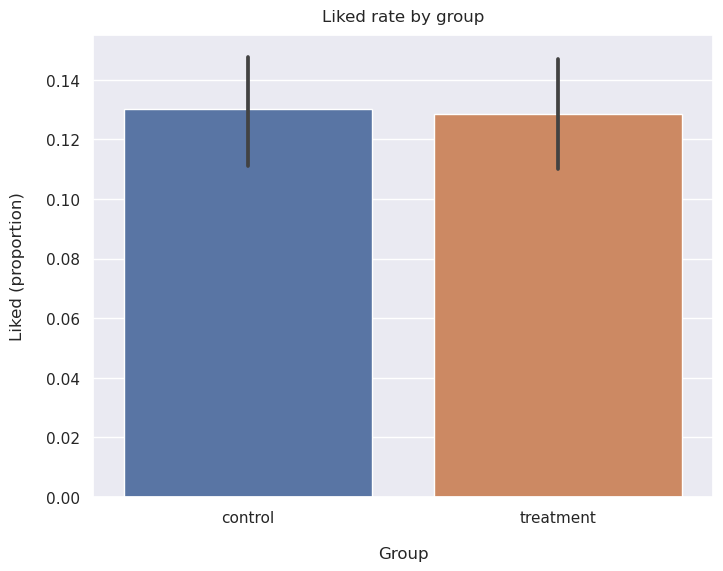

In [16]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['liked'])

plt.title('Liked rate by group', pad=10)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (proportion)', labelpad=15);

### Testing for Stat Sig

In [17]:
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the like count for both control and treatment groups
control_likes = control_results.sum()
treatment_likes = treatment_results.sum()

# Get the number of samples in both groups
control_size = control_results.count()
treatment_size = treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes = [control_likes, treatment_likes]

In [18]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(successes, nobs=[control_size, treatment_size]) #Test for proportions based on normal ztest

# Find the confidence interval for a binomial proportion for each test group
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes,
                                                                                        nobs=[control_size, treatment_size],
                                                                                        alpha=0.05)

In [22]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')
# print p-value
print(f'p value: {pval: .6f}')
# print ci 95% for control group
print(f'95% CI for control group: [{lower_control: .3f}, {upper_control: .3f}]')
# print ci 95% for treatment group
print(f'95% CI for treatment group: [{lower_treatment: .3f}, {upper_treatment: .3f}]')

z statistic: 0.12
p value:  0.903110
95% CI for control group: [ 0.111,  0.149]
95% CI for treatment group: [ 0.110,  0.147]


### Were the results signficant? 

In [24]:
print("No, our p value is too high and surpassed our a=0.05 threshold. Therefore, we failed to reject the null hypothesis.")

No, our p value is too high and surpassed our a=0.05 threshold. Therefore, we failed to reject the null hypothesis.


### What would you advise the engineering team to do moving forward?

In [26]:
print("Changing heart to star would be a bad idea because heart performed slighly better than star.")

Changing heart to star would be a bad idea because heart performed slighly better than star.
